In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

from torch import nn

from sklearn.metrics import mean_squared_error
from hython.preprocess import reshape, apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, SpaceSampler
from hython.metrics import mse_metric

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset

from hython.utils import missing_location_idx, reconstruct_from_missing, load
from hython.models.lstm import CustomLSTM

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler
from hython.utils import predict, prepare_for_plotting
from hython.viz import map_bias, map_pbias, map_pearson, map_at_timesteps, ts_compare, plot_sampler

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(43)

# Settings

In [ ]:
dynamic_names = ["precip", "pet", "temp"]
static_names = [ 'M', 'thetaS', 'RootingDepth', 'Kext', 'Sl', 'Swood', 'TT', 'KsatHorFrac'] 
target_names = [ "vwc","actevap" ] # "q_river"]

wflow_model = "adg1km_eobs" # "alps1km_eobs" # "alps1km_cerra", 

fn_forcings =  "forcings.nc" # 'inmaps_eobs_eobsd_makkink_86400_2015_2019.nc' # "forcings.nc"
fn_params = "staticmaps.nc"
fn_targets = "output.nc"


input_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/Wflow/models') / wflow_model
output_dir_path = Path('/mnt/CEPH_PROJECTS/InterTwin/surrogate/')
model_weigths_path = output_dir_path / "model_weights"
surrogate_input_path = Path("/mnt/CEPH_PROJECTS/InterTwin/hydrologic_data/surrogate_training")


In [ ]:
forcings = xr.open_dataset(input_dir_path / fn_forcings , chunks= {"time":100})
params = xr.open_dataset(input_dir_path / fn_params ,  chunks= {"time":100}).sel(layer=1)
targets = xr.open_dataset(input_dir_path / "run_default" / fn_targets, chunks= {"time":100}).sel(layer=1).isel(lat=slice(None, None, -1))

In [ ]:
# select forcings, wflow parameters and targets
forcings = forcings[dynamic_names]
params = params[static_names]
targets = targets[target_names]    

In [ ]:
try:
    forcings = forcings.rename({"latitude":"lat", "longitude":"lon"})
    params = params.rename({"latitude":"lat", "longitude":"lon"})
except:
    pass

# Hyper parameters

In [ ]:
# training 

spatial_batch_size = 128
temporal_sampling_size = 200 
seq_length = 30 # days

# model 

hidden_size = 64

model_params={
    "input_size": 3, #number of dynamic predictors - user_input
    "hidden_size": hidden_size, # user_input
    "output_size": len(target_names), # number_target - user_input
    "number_static_predictors": len(static_names), #number of static parameters - user_input 

}

## The used device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preprocess

In [ ]:
remove_lakes = True

if remove_lakes:
    mask_lakes = (targets.mean(dim = "time")["actevap"] == 0).astype(np.bool_)
    targets = targets.where(~mask_lakes, np.nan)
    forcings = forcings.where(~mask_lakes, np.nan)
    params = params.where(~mask_lakes, np.nan)


timeslice = slice("2014-01-01","2020-12-31")

if timeslice:
    forcings = forcings.sel(time=timeslice)
    targets = targets.sel(time=timeslice)

In [10]:
# UNCOMMENT IF NOT LOADING PREPROCESSED INPUTS

# #reshape for training

# Xd, Xs, Y  = reshape(
#                    forcings, 
#                    params, 
#                    targets
#                    )

# #Define the 2D missing values mask. Sampling 

# missing_mask = np.isnan(params.M).values

# UNCOMMENT TO SAVE
# np.savez_compressed( surrogate_input_path / f"{wflow_model}", Xd=Xd, Xs=Xs, Y=Y, missing_mask = missing_mask)

In [ ]:
# loading preprocessed data
Xd, Xs, Y, missing_mask = load(surrogate_input_path, wflow_model, files = ["Xd", "Xs", "Y", "missing_mask"])
Xd.shape, Xs.shape, Y.shape, missing_mask.shape

In [243]:
Xs.shape[0] - np.sum(np.isnan(Xs[...,0]))

15426

In [244]:
# Define the spatial samplers for both training and validation sets. Remeber they should not overlap.

intervals = (2, 2) # every n km
train_origin = (0, 0)
val_origin = (1, 1)

spatial_train_sampler = RegularIntervalSampler(intervals = intervals, origin = train_origin)
spatial_val_sampler = RegularIntervalSampler(intervals = intervals, origin = val_origin) 

In [245]:
# Apply the samplers to the 2D domain. The samplers return the cell indices that can be used later in training and validation.
data2d  = forcings.to_dataarray().transpose("lat","lon", "time", "variable")

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, missing_mask)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, missing_mask)

In [246]:
sampler_train_meta

SamplerResult(
 - id_grid_2d: (180, 223) 
 - idx_sampled_1d: (10080,) 
 - idx_sampled_1d_nomissing: (3857,))

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'layer = 1, spatial_ref = 0'}, xlabel='longitude coordinate\n[degrees_east]', ylabel='latitude coordinate\n[degrees_north]'>)

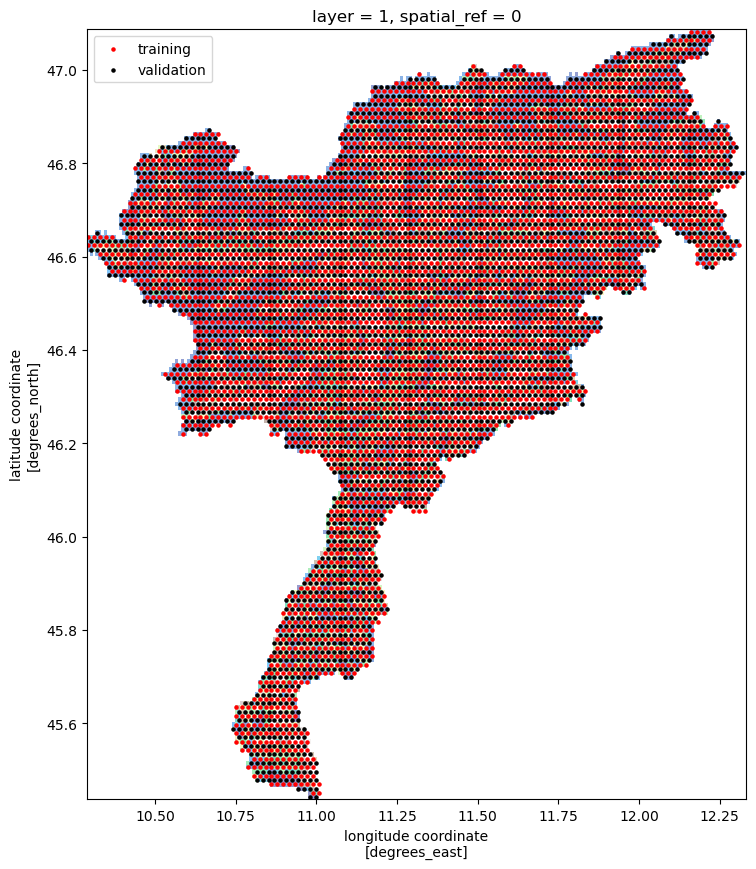

In [247]:
plot_sampler(params.Swood, sampler_train_meta, sampler_val_meta, figsize= (10, 10 ), markersize = 5)

In [248]:
# ## Normalizing v1
# # training
#Xd[sampler_train_meta.idx_sampled_1d_nomissing], d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
#Xs[sampler_train_meta.idx_sampled_1d_nomissing], s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
#Y[sampler_train_meta.idx_sampled_1d_nomissing], y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
# # validation 
# Xd[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Xd[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
# Xs[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Xs[sampler_val_meta.idx_sampled_1d_nomissing], type = "space", how ='standard', m1 = s_m, m2 = s_std)
# Y[sampler_val_meta.idx_sampled_1d_nomissing] = apply_normalization(Y[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = y_m, m2 = y_std)


# # Normalizing v2
# # training
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

d_m, s_m, y_m, d_std, s_std, y_std
# # validation 
# Xd_valid = apply_normalization(Xd[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = d_m, m2 = d_std)
# Xs_valid = apply_normalization(Xs[sampler_val_meta.idx_sampled_1d_nomissing], type = "space", how ='standard', m1 = s_m, m2 = s_std)
# Y_valid = apply_normalization(Y[sampler_val_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard', m1 = y_m, m2 = y_std)

(array([2.7047877, 1.8146279, 5.938555 ], dtype=float32),
 array([3.10963636e+02, 4.89665338e-01, 2.73866119e+02, 6.91087793e-01,
        6.10802160e-02, 2.31540544e-01, 0.00000000e+00, 1.00000000e+02]),
 array([0.23974535, 1.1458489 ], dtype=float32),
 array([5.9117355, 1.2365023, 8.228757 ], dtype=float32),
 array([7.44922859e+02, 2.19887555e-02, 1.18567233e+02, 7.24441378e-02,
        2.25483386e-02, 1.73434553e-01, 1.00000000e+00, 1.00000000e+00]),
 array([0.05658507, 0.88623315], dtype=float32))

In [249]:
Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std)
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std)
Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std)

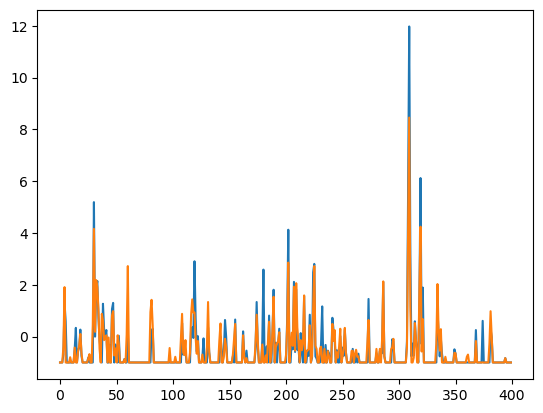

In [250]:
plt.plot(Xd[11_000,:400,0])
plt.plot(Xd[13_000,:400,0])

In [251]:
np.isnan(Xd[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_val_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_val_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

In [252]:
np.isnan(Xd[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Xs[sampler_train_meta.idx_sampled_1d_nomissing]).any(), np.isnan(Y[sampler_train_meta.idx_sampled_1d_nomissing]).any()

(False, False, False)

# Prepare Model inputs

In [265]:
Xs = torch.Tensor(Xs)
Xd = torch.Tensor(Xd)
Y = torch.Tensor(Y)

Xs.shape, Xd.shape, Y.shape

(torch.Size([40140, 8]),
 torch.Size([40140, 2557, 3]),
 torch.Size([40140, 2557, 2]))

In [266]:
# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

In [273]:
train_sampler = SpaceSampler(dataset, num_samples=1, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
valid_sampler = SpaceSampler(dataset, num_samples=1, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())

In [274]:
train_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=spatial_batch_size, shuffle=False, sampler = valid_sampler)

In [275]:
i = 0
for x,y,s in train_loader:
    print(x.shape, y.shape, s.shape)
    print(i)
    i += 1

torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
0
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
1
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
2
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
3
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
4
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
5
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
6
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
7
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
8
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
9
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
10
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
11
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])

In [276]:
i = 0
for x,y,s in val_loader:
    print(x.shape, y.shape, s.shape)
    print(i)
    i += 1

torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
0
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
1
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
2
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
3
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
4
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
5
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
6
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
7
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
8
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
9
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
10
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])
11
torch.Size([128, 2557, 3]) torch.Size([128, 8]) torch.Size([128, 2557, 2])

# Initialize Model

In [107]:
model = CustomLSTM(model_params)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=11, out_features=64, bias=True)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

# Train/valid settings

In [108]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-2)


loss_fn = nn.MSELoss()

## Set the metric function - here using the same loss function 
metric_fn = mse_metric

## Set the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 30


## Set the training parameters
params_train={
    "num_epochs": epochs,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": temporal_sampling_size,
    "seq_length": seq_length,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": ["vwc"] #target_names

}

# Run Train/valid

In [ ]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train, plot= False)

In [ ]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history['train_vwc']
val_loss = sm_metric_history['val_vwc']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# Extract the loss values
train_loss = sm_metric_history['train_actevap']
val_loss = sm_metric_history['val_actevap']

# Create a list of epochs for the x-axis (e.g., [1, 2, 3, ..., 100])
lepochs = list(range(1,params_train["num_epochs"] + 1))

# Create the train and validation loss plots
plt.figure(figsize=(10, 6))
plt.plot(lepochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(lepochs, val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Validation Loss - SM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
model.load_state_dict(torch.load(params_train["path2weights"]))

<All keys matched successfully>

In [39]:
##model= model.to('cuda:0')
#model= model.to('cpu')
#it = iter(train_loader)
# din, static, val = next(it)
# din.shape, static.shape, val.shape
# plt.figure(figsize=(20,10)) 
# plt.plot(model(din, static).detach().cpu().numpy()[101,:,1], label ="model")
# plt.plot(val[101,:,1], label="val")
# plt.legend()

# Inference 

In [60]:
torch.cuda.empty_cache()

In [61]:
yhat = predict(Xd, Xs, model, spatial_batch_size, device="cpu")
yhat.shape

(40140, 2557, 1)

In [62]:
lat, lon, time = *forcings.to_dataarray().transpose("lat","lon", "time", "variable").shape[:2], Xd.shape[1]
lat*lon ,time

(40140, 2557)

## SM

In [ ]:
y_target, y_pred = prepare_for_plotting(y_target=Y[:,:,[0]], y_pred = yhat[:,:,[0]], shape = (lat, lon, time), coords = targets[target_names].coords)
y_target.shape

In [ ]:
map_pbias(y_target, y_pred, figsize = (12, 12)) #, kwargs_imshow = {"vmin":-100, "vmax":100 })

In [ ]:
#map_pearson(y_target, y_pred)

In [68]:
np.unique(yhat)

array([0.2836614,       nan], dtype=float32)

In [ ]:
ts_compare(y_target, y_pred, lat = [45, 46.5, 46.3], lon = [10, 11.3, 11.3])

## ET

In [49]:
y_target_et, y_pred_et = prepare_for_plotting(y_target=Y[:,:,[1]], y_pred = yhat[:,:,[1]], shape = (lat, lon, time), coords = targets.coords)
y_target_et.shape

(689, 1177, 1461)

In [ ]:
map_pbias(y_target, y_pred, figsize = (12, 12)) #, kwargs_imshow = {"vmin":-100, "vmax":100 })

In [ ]:
ts_compare(y_target_et, y_pred_et, lat = [46.4, 46.5, 46.3], lon = [11.4, 11.3, 11.3])